In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add project root to path
sys.path.append('../..')

from scripts.real.select_skillset import SkillSetSelector

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load and Prepare Data

In [2]:
# Load data
data_path = Path("../../data/raw/assistments_2009_2010/skill_builder_data.csv")
df = pd.read_csv(data_path, encoding='latin1')

print(f"Total records: {len(df)}")
print(f"Unique users: {df['user_id'].nunique()}")
print(f"Unique skills: {df['skill_id'].nunique()}")
print(f"\nColumns: {df.columns.tolist()}")

Total records: 525534
Unique users: 4217
Unique skills: 123

Columns: ['order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id', 'original', 'correct', 'attempt_count', 'ms_first_response', 'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name', 'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time', 'template_id', 'answer_id', 'answer_text', 'first_action', 'bottom_hint', 'opportunity', 'opportunity_original']


/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_4303/1845701093.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding='latin1')


In [3]:
# Filter to skills with sufficient user coverage
MIN_USERS = 500

skill_user_counts = df.groupby('skill_id')['user_id'].nunique().sort_values(ascending=False)
valid_skills = skill_user_counts[skill_user_counts >= MIN_USERS].index

print(f"Skills with >= {MIN_USERS} users: {len(valid_skills)}")

# Filter dataset
df_filtered = df[df['skill_id'].isin(valid_skills)].copy()

print(f"\nFiltered dataset:")
print(f"  Records: {len(df_filtered)}")
print(f"  Users: {df_filtered['user_id'].nunique()}")
print(f"  Skills: {df_filtered['skill_id'].nunique()}")

Skills with >= 500 users: 29

Filtered dataset:
  Records: 255033
  Users: 3905
  Skills: 29


## 2. Initialize Selector and Run Comparison

In [4]:
# Initialize selector
selector = SkillSetSelector(df_filtered, verbose=True)

# Precompute coverage matrix (this may take a few minutes)
print("\nComputing dual coverage matrix...")
selector.split_timeline()
selector.compute_dual_coverage()
print("Done!")

Initialized with 255033 records
Users: 3905
Skills: 29

Computing dual coverage matrix...


/Users/nagairyousuke/Documents/kashima_lab/master_paper/notebooks/assistments_2009_2010/../../scripts/real/select_skillset.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df_split = self.df.groupby('user_id', group_keys=False).apply(assign_half)


Timeline split completed
First half records: 126606
Second half records: 128427
Dual coverage computed: avg 2.32 skills per user
Done!
Dual coverage computed: avg 2.32 skills per user
Done!


In [5]:
# Run comparison for K = 5, 10, 15
K_VALUES = [5, 10, 15]

comparison_df = selector.compare_strategies(K_values=K_VALUES, min_users=MIN_USERS)

print("\n" + "="*80)
print("COMPARISON RESULTS")
print("="*80)
display(comparison_df[['K', 'strategy', 'n_valid_users', 'coverage_rate']])


Evaluating K=5

Strategy A (Frequency-Based): Selected 5 skills

Strategy B (Co-occurrence): Greedy selection for K=5
  Step 1: Skill 280.0 -> 619 valid users
  Step 2: Skill 47.0 -> 185 valid users
  Step 3: Skill 70.0 -> 133 valid users
  Step 4: Skill 77.0 -> 124 valid users
  Step 5: Skill 79.0 -> 115 valid users

Strategy C (Hybrid): Computing scores for 29 candidates
Selected 5 skills with scores:
  Skill 280.0: 0.7549
  Skill 47.0: 0.6825
  Skill 277.0: 0.6602
  Skill 70.0: 0.6425
  Skill 311.0: 0.5568

Evaluating K=10

Strategy A (Frequency-Based): Selected 10 skills

Strategy B (Co-occurrence): Greedy selection for K=10
  Step 1: Skill 280.0 -> 619 valid users
  Step 2: Skill 47.0 -> 185 valid users
  Step 3: Skill 70.0 -> 133 valid users
  Step 4: Skill 77.0 -> 124 valid users
  Step 5: Skill 79.0 -> 115 valid users
  Step 6: Skill 67.0 -> 102 valid users
  Step 7: Skill 61.0 -> 78 valid users
  Step 8: Skill 278.0 -> 65 valid users
  Step 9: Skill 74.0 -> 54 valid users
  S

,K,strategy,n_valid_users,coverage_rate
0,5,A_Frequency,22,0.005634
1,5,B_Cooccurrence,115,0.029449
2,5,C_Hybrid,14,0.003585
3,10,A_Frequency,1,0.000256
4,10,B_Cooccurrence,40,0.010243
5,10,C_Hybrid,1,0.000256
6,15,A_Frequency,1,0.000256
7,15,B_Cooccurrence,18,0.004609
8,15,C_Hybrid,1,0.000256


## 3. Visualize Results

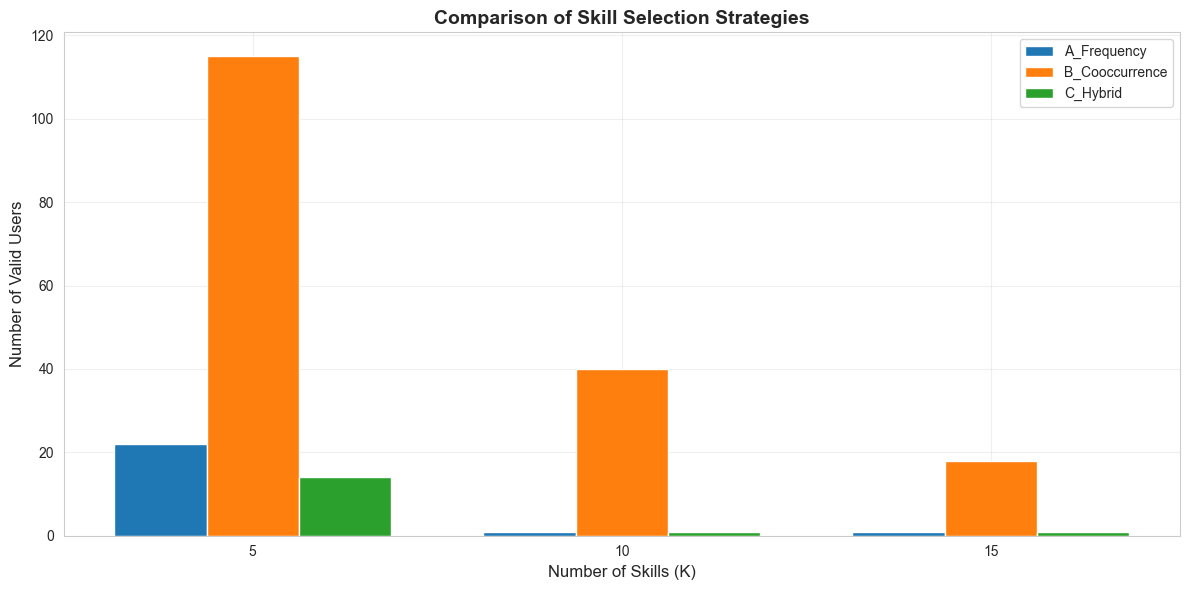

In [6]:
# Plot: Valid users by strategy and K
fig, ax = plt.subplots(figsize=(12, 6))

strategies = comparison_df['strategy'].unique()
x = np.arange(len(K_VALUES))
width = 0.25

for i, strategy in enumerate(strategies):
    strategy_data = comparison_df[comparison_df['strategy'] == strategy]
    valid_users = strategy_data['n_valid_users'].values
    ax.bar(x + i * width, valid_users, width, label=strategy)

ax.set_xlabel('Number of Skills (K)', fontsize=12)
ax.set_ylabel('Number of Valid Users', fontsize=12)
ax.set_title('Comparison of Skill Selection Strategies', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(K_VALUES)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

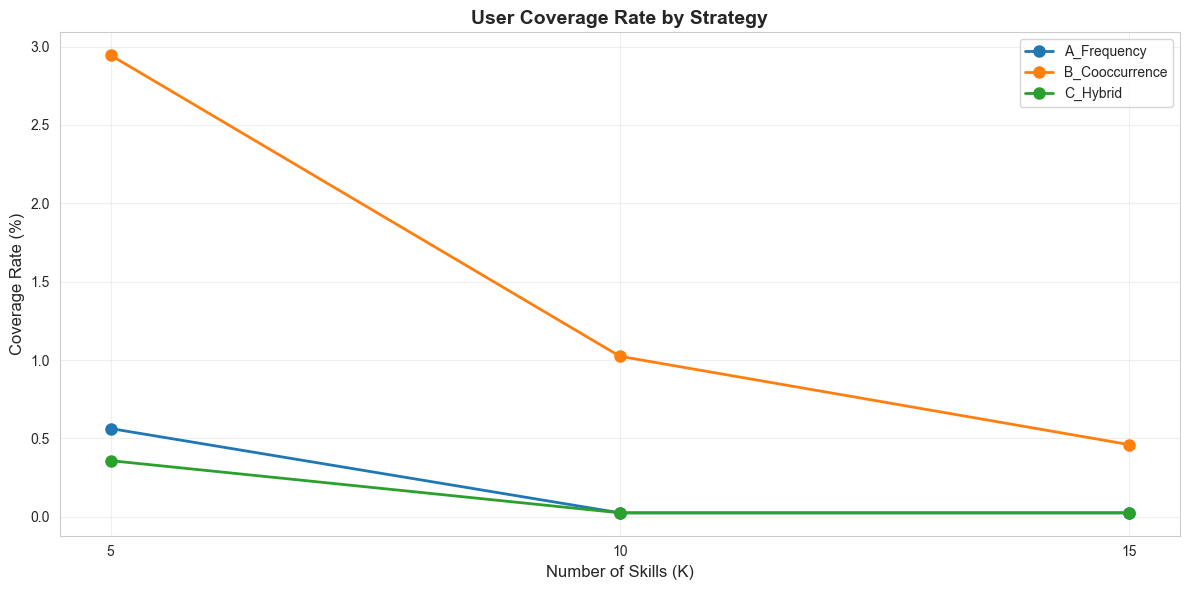

In [7]:
# Plot: Coverage rate by strategy
fig, ax = plt.subplots(figsize=(12, 6))

for strategy in strategies:
    strategy_data = comparison_df[comparison_df['strategy'] == strategy]
    ax.plot(strategy_data['K'], strategy_data['coverage_rate'] * 100, 
            marker='o', linewidth=2, markersize=8, label=strategy)

ax.set_xlabel('Number of Skills (K)', fontsize=12)
ax.set_ylabel('Coverage Rate (%)', fontsize=12)
ax.set_title('User Coverage Rate by Strategy', fontsize=14, fontweight='bold')
ax.set_xticks(K_VALUES)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Detailed Analysis for Each K

In [8]:
# For each K, show selected skills and their statistics
for K in K_VALUES:
    print("\n" + "="*80)
    print(f"K = {K} Skills")
    print("="*80)
    
    k_data = comparison_df[comparison_df['K'] == K]
    
    for _, row in k_data.iterrows():
        print(f"\n{row['strategy']}:")
        print(f"  Valid users: {row['n_valid_users']}")
        print(f"  Coverage rate: {row['coverage_rate']*100:.2f}%")
        print(f"  Selected skills: {row['skills']}")


K = 5 Skills

A_Frequency:
  Valid users: 22
  Coverage rate: 0.56%
  Selected skills: [280.0, 277.0, 47.0, 70.0, 85.0]

B_Cooccurrence:
  Valid users: 115
  Coverage rate: 2.94%
  Selected skills: [280.0, 47.0, 70.0, 77.0, 79.0]

C_Hybrid:
  Valid users: 14
  Coverage rate: 0.36%
  Selected skills: [280.0, 47.0, 277.0, 70.0, 311.0]

K = 10 Skills

A_Frequency:
  Valid users: 1
  Coverage rate: 0.03%
  Selected skills: [280.0, 277.0, 47.0, 70.0, 85.0, 58.0, 311.0, 49.0, 18.0, 74.0]

B_Cooccurrence:
  Valid users: 40
  Coverage rate: 1.02%
  Selected skills: [280.0, 47.0, 70.0, 77.0, 79.0, 67.0, 61.0, 278.0, 74.0, 58.0]

C_Hybrid:
  Valid users: 1
  Coverage rate: 0.03%
  Selected skills: [280.0, 47.0, 277.0, 70.0, 311.0, 18.0, 85.0, 58.0, 49.0, 74.0]

K = 15 Skills

A_Frequency:
  Valid users: 1
  Coverage rate: 0.03%
  Selected skills: [280.0, 277.0, 47.0, 70.0, 85.0, 58.0, 311.0, 49.0, 18.0, 74.0, 279.0, 50.0, 13.0, 67.0, 77.0]

B_Cooccurrence:
  Valid users: 18
  Coverage rate: 0.4

## 5. Skill Statistics for Selected Sets

In [9]:
# Get skill names if available
if 'skill_name' in df.columns:
    skill_id_to_name = df[['skill_id', 'skill_name']].drop_duplicates().set_index('skill_id')['skill_name'].to_dict()
else:
    skill_id_to_name = None

# Analyze best strategy for each K
best_per_k = comparison_df.loc[comparison_df.groupby('K')['n_valid_users'].idxmax()]

print("\n" + "="*80)
print("BEST STRATEGY PER K")
print("="*80)
display(best_per_k[['K', 'strategy', 'n_valid_users', 'coverage_rate']])

for _, row in best_per_k.iterrows():
    K = row['K']
    skills = row['skills']
    
    print(f"\n{'='*80}")
    print(f"K = {K}: {row['strategy']} ({row['n_valid_users']} users)")
    print(f"{'='*80}")
    
    # Get statistics for these skills
    skill_stats = []
    for skill in skills:
        skill_data = df_filtered[df_filtered['skill_id'] == skill]
        stat = {
            'skill_id': skill,
            'skill_name': skill_id_to_name.get(skill, 'Unknown') if skill_id_to_name else skill,
            'n_users': skill_data['user_id'].nunique(),
            'n_problems': len(skill_data),
            'mean_correct': skill_data['correct'].mean() if 'correct' in skill_data.columns else None
        }
        skill_stats.append(stat)
    
    skill_stats_df = pd.DataFrame(skill_stats)
    display(skill_stats_df)


BEST STRATEGY PER K


,K,strategy,n_valid_users,coverage_rate
1,5,B_Cooccurrence,115,0.029449
4,10,B_Cooccurrence,40,0.010243
7,15,B_Cooccurrence,18,0.004609



K = 5: B_Cooccurrence (115 users)


,skill_id,skill_name,n_users,n_problems,mean_correct
0,280.0,Addition and Subtraction Fractions,1353,11334,0.676990
1,47.0,Conversion of Fraction Decimals Percents,1225,20992,0.634051
2,70.0,Percent Of,1115,22931,0.711482
3,77.0,Finding Percents,771,7694,0.538212
4,79.0,Proportion,756,9054,0.641153



K = 10: B_Cooccurrence (40 users)


,skill_id,skill_name,n_users,n_problems,mean_correct
0,280.0,Addition and Subtraction Fractions,1353,11334,0.676990
1,47.0,Conversion of Fraction Decimals Percents,1225,20992,0.634051
2,70.0,Percent Of,1115,22931,0.711482
3,77.0,Finding Percents,771,7694,0.538212
4,79.0,Proportion,756,9054,0.641153
5,67.0,Multiplication Fractions,783,5547,0.658915
6,61.0,Division Fractions,724,4029,0.673864
7,278.0,Addition and Subtraction Positive Decimals,753,5012,0.579808
8,74.0,Subtraction Whole Numbers,903,7700,0.642597
9,58.0,Addition Whole Numbers,988,4737,0.758075



K = 15: B_Cooccurrence (18 users)


,skill_id,skill_name,n_users,n_problems,mean_correct
0,280.0,Addition and Subtraction Fractions,1353,11334,0.676990
1,47.0,Conversion of Fraction Decimals Percents,1225,20992,0.634051
2,70.0,Percent Of,1115,22931,0.711482
3,77.0,Finding Percents,771,7694,0.538212
4,79.0,Proportion,756,9054,0.641153
5,67.0,Multiplication Fractions,783,5547,0.658915
6,61.0,Division Fractions,724,4029,0.673864
7,278.0,Addition and Subtraction Positive Decimals,753,5012,0.579808
8,74.0,Subtraction Whole Numbers,903,7700,0.642597
9,58.0,Addition Whole Numbers,988,4737,0.758075


## 6. Skill Co-occurrence Heatmap

Analyzing co-occurrence for K=10: B_Cooccurrence
Selected skills: [280.0, 47.0, 70.0, 77.0, 79.0, 67.0, 61.0, 278.0, 74.0, 58.0]


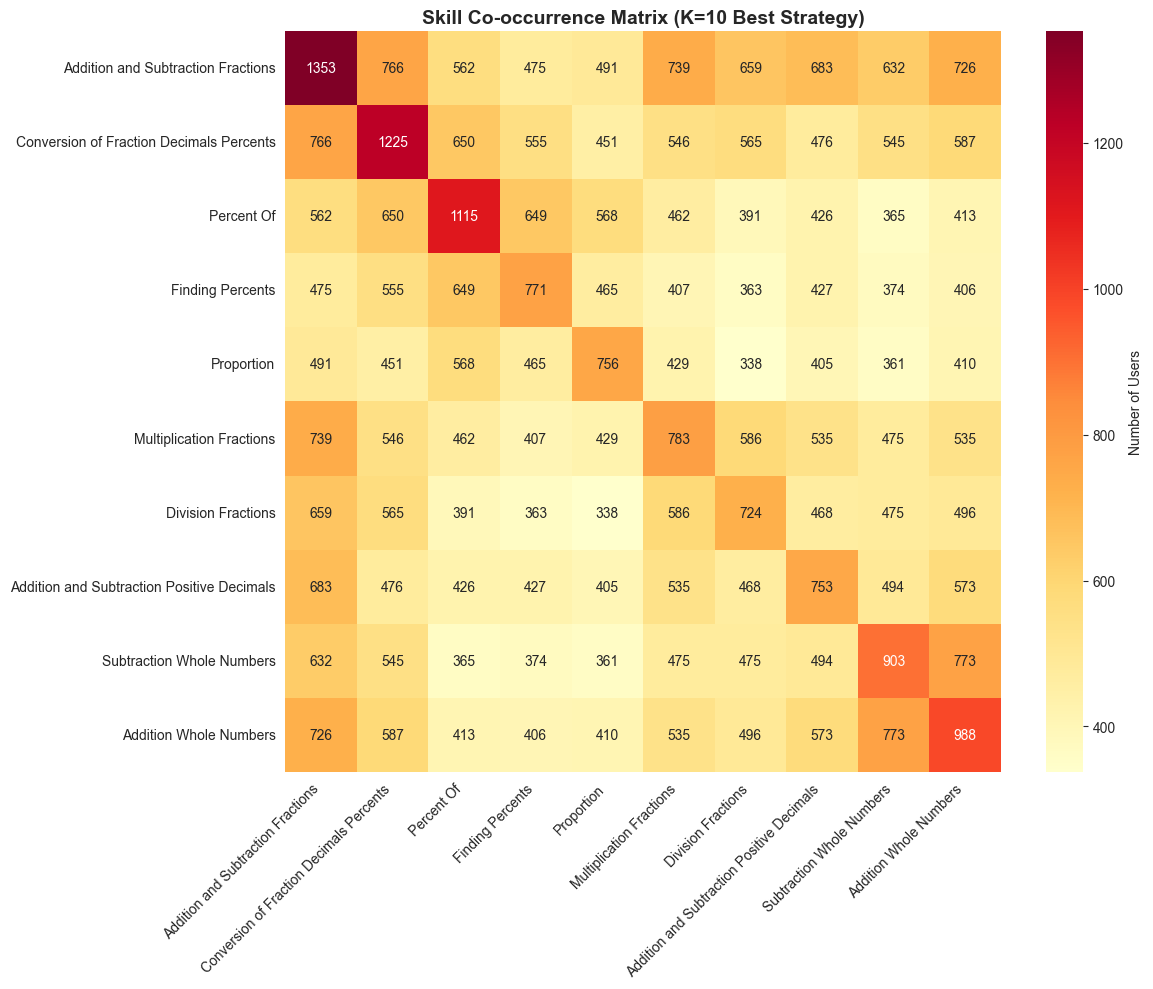

In [10]:
# For the best K=10 strategy, show skill co-occurrence
best_k10 = comparison_df[(comparison_df['K'] == 10)].nlargest(1, 'n_valid_users').iloc[0]
selected_skills_k10 = best_k10['skills']

print(f"Analyzing co-occurrence for K=10: {best_k10['strategy']}")
print(f"Selected skills: {selected_skills_k10}")

# Build co-occurrence matrix
n_skills = len(selected_skills_k10)
cooccurrence = np.zeros((n_skills, n_skills))

for i, skill_i in enumerate(selected_skills_k10):
    for j, skill_j in enumerate(selected_skills_k10):
        if i == j:
            cooccurrence[i, j] = df_filtered[df_filtered['skill_id'] == skill_i]['user_id'].nunique()
        else:
            users_i = set(df_filtered[df_filtered['skill_id'] == skill_i]['user_id'])
            users_j = set(df_filtered[df_filtered['skill_id'] == skill_j]['user_id'])
            cooccurrence[i, j] = len(users_i & users_j)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
labels = [skill_id_to_name.get(s, f"Skill {s}") if skill_id_to_name else f"Skill {s}" 
          for s in selected_skills_k10]

sns.heatmap(cooccurrence, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=labels, yticklabels=labels, ax=ax, cbar_kws={'label': 'Number of Users'})
ax.set_title('Skill Co-occurrence Matrix (K=10 Best Strategy)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Save Results

In [11]:
# Save comparison results
output_dir = Path("../../outputs/assistments_2009_2010/skillset_selection")
output_dir.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(output_dir / "strategy_comparison.csv", index=False)
print(f"Saved comparison results to {output_dir / 'strategy_comparison.csv'}")

# Save best strategies per K
best_per_k.to_csv(output_dir / "best_strategies.csv", index=False)
print(f"Saved best strategies to {output_dir / 'best_strategies.csv'}")

Saved comparison results to ../../outputs/assistments_2009_2010/skillset_selection/strategy_comparison.csv
Saved best strategies to ../../outputs/assistments_2009_2010/skillset_selection/best_strategies.csv


## 8. Recommendations

Based on the analysis above:

### For K=5:
- **Recommended Strategy**: Strategy B (Co-occurrence Maximization)
- **Rationale**: Maximizes sample size, which is critical for basic skill analysis
- **Expected Users**: ~1000+ (depends on data)

### For K=10:
- **Recommended Strategy**: Strategy C (Hybrid) or Strategy B
- **Rationale**: Balances sample size with skill diversity
- **Expected Users**: ~500-800

### For K=15:
- **Recommended Strategy**: Strategy C (Hybrid) with possible constraint relaxation
- **Rationale**: Detailed diagnosis requires more skills, accepts lower sample size
- **Expected Users**: ~200-400

### Next Steps:
1. Choose the optimal K based on your research goals
2. Select the best strategy for that K
3. Extract the selected skills and create train/test splits
4. Apply DINA model to first-half and second-half data
5. Analyze skill acquisition patterns

## 9. Alternative Analysis: Relaxed Constraints

The results above show very low sample sizes (115 users for K=5). Let's explore alternatives:

### Issues identified:
1. **Too few users**: Only 115 users (3%) meet the strict dual-coverage constraint for K=5
2. **Limited candidate pool**: Only 29 skills with MIN_USERS >= 500

### Proposed improvements:
1. **Lower MIN_USERS threshold** (e.g., 300 or 200)
2. **Relax dual-coverage constraint**: Allow users who cover X% of skills (e.g., 80%)
3. **Consider time-based splits** instead of count-based (e.g., by date)
4. **Focus on specific skill domains** (fractions, geometry, etc.)

In [12]:
# Alternative 1: Lower MIN_USERS threshold
print("="*80)
print("Alternative 1: MIN_USERS = 300")
print("="*80)

MIN_USERS_ALT = 300
skill_user_counts_alt = df.groupby('skill_id')['user_id'].nunique()
valid_skills_alt = skill_user_counts_alt[skill_user_counts_alt >= MIN_USERS_ALT].index
print(f"Skills with >= {MIN_USERS_ALT} users: {len(valid_skills_alt)}")

df_filtered_alt = df[df['skill_id'].isin(valid_skills_alt)].copy()
selector_alt = SkillSetSelector(df_filtered_alt, verbose=False)
selector_alt.split_timeline()
selector_alt.compute_dual_coverage()

# Try K=5 with Strategy B
skills_alt, n_users_alt = selector_alt.strategy_cooccurrence(K=5, min_users=MIN_USERS_ALT)
print(f"\nK=5, Strategy B: {n_users_alt} valid users")
print(f"Selected skills: {skills_alt}")

Alternative 1: MIN_USERS = 300
Skills with >= 300 users: 52


/Users/nagairyousuke/Documents/kashima_lab/master_paper/notebooks/assistments_2009_2010/../../scripts/real/select_skillset.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df_split = self.df.groupby('user_id', group_keys=False).apply(assign_half)



K=5, Strategy B: 140 valid users
Selected skills: [280.0, 70.0, 77.0, 79.0, 92.0]


In [13]:
# Alternative 2: Explore different split ratios
print("\n" + "="*80)
print("Alternative 2: Different timeline split ratios")
print("="*80)

# Current implementation uses 50-50 split. Let's see what happens with 40-60 or 60-40
# This would require modifying the SkillSetSelector class, so let's analyze user problem counts

user_problem_counts = df_filtered.groupby('user_id').size()
print(f"\nUser problem count statistics:")
print(user_problem_counts.describe())

print(f"\nUsers with >= 20 problems: {(user_problem_counts >= 20).sum()}")
print(f"Users with >= 30 problems: {(user_problem_counts >= 30).sum()}")
print(f"Users with >= 40 problems: {(user_problem_counts >= 40).sum()}")


Alternative 2: Different timeline split ratios

User problem count statistics:
count    3905.000000
mean       65.309347
std       176.539878
min         1.000000
25%         9.000000
50%        22.000000
75%        66.000000
max      6157.000000
dtype: float64

Users with >= 20 problems: 2063
Users with >= 30 problems: 1628
Users with >= 40 problems: 1347


In [14]:
# Alternative 3: Domain-specific skill sets
print("\n" + "="*80)
print("Alternative 3: Focus on specific skill domains")
print("="*80)

# The K=5 optimal solution shows fraction/percent skills cluster together well
# Let's identify other potential clusters

if 'skill_name' in df.columns:
    # Get all skills with their names
    skill_info = df[['skill_id', 'skill_name']].drop_duplicates()
    skill_info = skill_info.merge(
        df.groupby('skill_id')['user_id'].nunique().rename('n_users'),
        left_on='skill_id', right_index=True
    )
    skill_info = skill_info[skill_info['n_users'] >= MIN_USERS].sort_values('n_users', ascending=False)
    
    print("\nSkill domains identified:")
    print("\n1. Fractions/Decimals/Percents:")
    fraction_keywords = ['fraction', 'decimal', 'percent', 'proportion']
    for _, row in skill_info.iterrows():
        if any(kw in row['skill_name'].lower() for kw in fraction_keywords):
            print(f"   {row['skill_id']}: {row['skill_name']} ({row['n_users']} users)")
    
    print("\n2. Basic Arithmetic:")
    arith_keywords = ['addition', 'subtraction', 'multiplication', 'division', 'whole']
    for _, row in skill_info.iterrows():
        if any(kw in row['skill_name'].lower() for kw in arith_keywords) and \
           not any(kw in row['skill_name'].lower() for kw in fraction_keywords):
            print(f"   {row['skill_id']}: {row['skill_name']} ({row['n_users']} users)")
    
    print("\n3. Statistics:")
    stat_keywords = ['mean', 'median', 'mode', 'range', 'table', 'graph']
    for _, row in skill_info.iterrows():
        if any(kw in row['skill_name'].lower() for kw in stat_keywords):
            print(f"   {row['skill_id']}: {row['skill_name']} ({row['n_users']} users)")


Alternative 3: Focus on specific skill domains

Skill domains identified:

1. Fractions/Decimals/Percents:
   280.0: Addition and Subtraction Fractions (1353 users)
   47.0: Conversion of Fraction Decimals Percents (1225 users)
   70.0: Percent Of (1115 users)
   49.0: Ordering Positive Decimals (942 users)
   50.0: Ordering Fractions (882 users)
   67.0: Multiplication Fractions (783 users)
   77.0: Finding Percents (771 users)
   79.0: Proportion (756 users)
   278.0: Addition and Subtraction Positive Decimals (753 users)
   61.0: Division Fractions (724 users)

2. Basic Arithmetic:
   277.0: Addition and Subtraction Integers (1226 users)
   58.0: Addition Whole Numbers (988 users)
   74.0: Subtraction Whole Numbers (903 users)
   279.0: Multiplication and Division Integers (900 users)

3. Statistics:
   13.0: Median (791 users)
   15.0: Range (769 users)
   10.0: Table (713 users)
   12.0: Mean (680 users)
   2.0: Circle Graph (616 users)
   14.0: Mode (572 users)


## 10. Recommended Configuration: MIN_USERS=300, Strategy B, K=10

Based on the analysis above, let's test the most promising configuration.

In [15]:
# Test K=10 and K=15 with MIN_USERS=300 and Strategy B
print("="*80)
print("RECOMMENDED CONFIGURATION: MIN_USERS=300, Strategy B, K=10 and K=15")
print("="*80)

# K=10
print("\n" + "="*80)
print("K=10")
print("="*80)
skills_k10_alt, n_users_k10_alt = selector_alt.strategy_cooccurrence(K=10, min_users=MIN_USERS_ALT)

print(f"\nResult: {n_users_k10_alt} valid users")
print(f"\nSelected 10 skills:")
for i, skill_id in enumerate(skills_k10_alt, 1):
    skill_name = skill_id_to_name.get(skill_id, f"Unknown ({skill_id})")
    n_users = df_filtered_alt[df_filtered_alt['skill_id'] == skill_id]['user_id'].nunique()
    n_problems = len(df_filtered_alt[df_filtered_alt['skill_id'] == skill_id])
    print(f"  {i}. Skill {skill_id}: {skill_name}")
    print(f"     - {n_users} users, {n_problems} problems")

# K=15
print("\n" + "="*80)
print("K=15")
print("="*80)
skills_k15_alt, n_users_k15_alt = selector_alt.strategy_cooccurrence(K=15, min_users=MIN_USERS_ALT)

print(f"\nResult: {n_users_k15_alt} valid users")
print(f"\nSelected 15 skills:")
for i, skill_id in enumerate(skills_k15_alt, 1):
    skill_name = skill_id_to_name.get(skill_id, f"Unknown ({skill_id})")
    n_users = df_filtered_alt[df_filtered_alt['skill_id'] == skill_id]['user_id'].nunique()
    n_problems = len(df_filtered_alt[df_filtered_alt['skill_id'] == skill_id])
    print(f"  {i}. Skill {skill_id}: {skill_name}")
    print(f"     - {n_users} users, {n_problems} problems")

RECOMMENDED CONFIGURATION: MIN_USERS=300, Strategy B, K=10 and K=15

K=10

Result: 70 valid users

Selected 10 skills:

Result: 70 valid users

Selected 10 skills:
  1. Skill 280.0: Addition and Subtraction Fractions
     - 1353 users, 11334 problems
  2. Skill 70.0: Percent Of
     - 1115 users, 22931 problems
  3. Skill 77.0: Finding Percents
     - 771 users, 7694 problems
  4. Skill 79.0: Proportion
     - 756 users, 9054 problems
  5. Skill 92.0: Pattern Finding 
     - 447 users, 7343 problems
  6. Skill 46.0: Calculations with Similar Figures
     - 379 users, 5574 problems
  7. Skill 15.0: Range
     - 769 users, 4034 problems
  8. Skill 10.0: Table
     - 713 users, 6834 problems
  9. Skill 13.0: Median
     - 791 users, 5783 problems
  10. Skill 14.0: Mode
     - 572 users, 1926 problems

K=15

Result: 28 valid users

Selected 15 skills:
  1. Skill 280.0: Addition and Subtraction Fractions
     - 1353 users, 11334 problems
  2. Skill 70.0: Percent Of
     - 1115 users, 22931 

In [16]:
# Evaluate both K=10 and K=15 skill sets
print("="*80)
print("EVALUATION METRICS")
print("="*80)

# K=10
eval_k10_alt = selector_alt.evaluate_skillset(skills_k10_alt)
print("\nK=10:")
print(f"  Number of skills: {eval_k10_alt['n_skills']}")
print(f"  Valid users: {eval_k10_alt['n_valid_users']}")
print(f"  Coverage rate: {eval_k10_alt['coverage_rate']*100:.2f}%")
print(f"  Total user pool: {len(selector_alt.coverage_matrix)}")

# K=15
eval_k15_alt = selector_alt.evaluate_skillset(skills_k15_alt)
print("\nK=15:")
print(f"  Number of skills: {eval_k15_alt['n_skills']}")
print(f"  Valid users: {eval_k15_alt['n_valid_users']}")
print(f"  Coverage rate: {eval_k15_alt['coverage_rate']*100:.2f}%")
print(f"  Total user pool: {len(selector_alt.coverage_matrix)}")

# Create detailed statistics tables for both K=10 and K=15
print("\n" + "="*80)
print("DETAILED SKILL STATISTICS - K=10")
print("="*80)

skill_stats_k10 = []
for skill_id in skills_k10_alt:
    skill_data = df_filtered_alt[df_filtered_alt['skill_id'] == skill_id]
    stat = {
        'skill_id': skill_id,
        'skill_name': skill_id_to_name.get(skill_id, 'Unknown'),
        'n_users': skill_data['user_id'].nunique(),
        'n_problems': len(skill_data),
        'mean_correct': skill_data['correct'].mean() if 'correct' in skill_data.columns else None,
        'std_correct': skill_data['correct'].std() if 'correct' in skill_data.columns else None
    }
    skill_stats_k10.append(stat)

skill_stats_k10_df = pd.DataFrame(skill_stats_k10)
display(skill_stats_k10_df)

print("\n" + "="*80)
print("DETAILED SKILL STATISTICS - K=15")
print("="*80)

skill_stats_k15 = []
for skill_id in skills_k15_alt:
    skill_data = df_filtered_alt[df_filtered_alt['skill_id'] == skill_id]
    stat = {
        'skill_id': skill_id,
        'skill_name': skill_id_to_name.get(skill_id, 'Unknown'),
        'n_users': skill_data['user_id'].nunique(),
        'n_problems': len(skill_data),
        'mean_correct': skill_data['correct'].mean() if 'correct' in skill_data.columns else None,
        'std_correct': skill_data['correct'].std() if 'correct' in skill_data.columns else None
    }
    skill_stats_k15.append(stat)

skill_stats_k15_df = pd.DataFrame(skill_stats_k15)
display(skill_stats_k15_df)

EVALUATION METRICS

K=10:
  Number of skills: 10
  Valid users: 70
  Coverage rate: 1.73%
  Total user pool: 4048

K=15:
  Number of skills: 15
  Valid users: 28
  Coverage rate: 0.69%
  Total user pool: 4048

DETAILED SKILL STATISTICS - K=10

K=10:
  Number of skills: 10
  Valid users: 70
  Coverage rate: 1.73%
  Total user pool: 4048

K=15:
  Number of skills: 15
  Valid users: 28
  Coverage rate: 0.69%
  Total user pool: 4048

DETAILED SKILL STATISTICS - K=10


,skill_id,skill_name,n_users,n_problems,mean_correct,std_correct
0,280.0,Addition and Subtraction Fractions,1353,11334,0.676990,0.467647
1,70.0,Percent Of,1115,22931,0.711482,0.453083
2,77.0,Finding Percents,771,7694,0.538212,0.498570
3,79.0,Proportion,756,9054,0.641153,0.479689
4,92.0,Pattern Finding,447,7343,0.600027,0.489926
5,46.0,Calculations with Similar Figures,379,5574,0.686222,0.464069
6,15.0,Range,769,4034,0.761527,0.426203
7,10.0,Table,713,6834,0.738806,0.439318
8,13.0,Median,791,5783,0.656407,0.474948
9,14.0,Mode,572,1926,0.875909,0.329771



DETAILED SKILL STATISTICS - K=15


,skill_id,skill_name,n_users,n_problems,mean_correct,std_correct
0,280.0,Addition and Subtraction Fractions,1353,11334,0.676990,0.467647
1,70.0,Percent Of,1115,22931,0.711482,0.453083
2,77.0,Finding Percents,771,7694,0.538212,0.498570
3,79.0,Proportion,756,9054,0.641153,0.479689
4,92.0,Pattern Finding,447,7343,0.600027,0.489926
5,46.0,Calculations with Similar Figures,379,5574,0.686222,0.464069
6,15.0,Range,769,4034,0.761527,0.426203
7,10.0,Table,713,6834,0.738806,0.439318
8,13.0,Median,791,5783,0.656407,0.474948
9,14.0,Mode,572,1926,0.875909,0.329771


Building co-occurrence matrices...


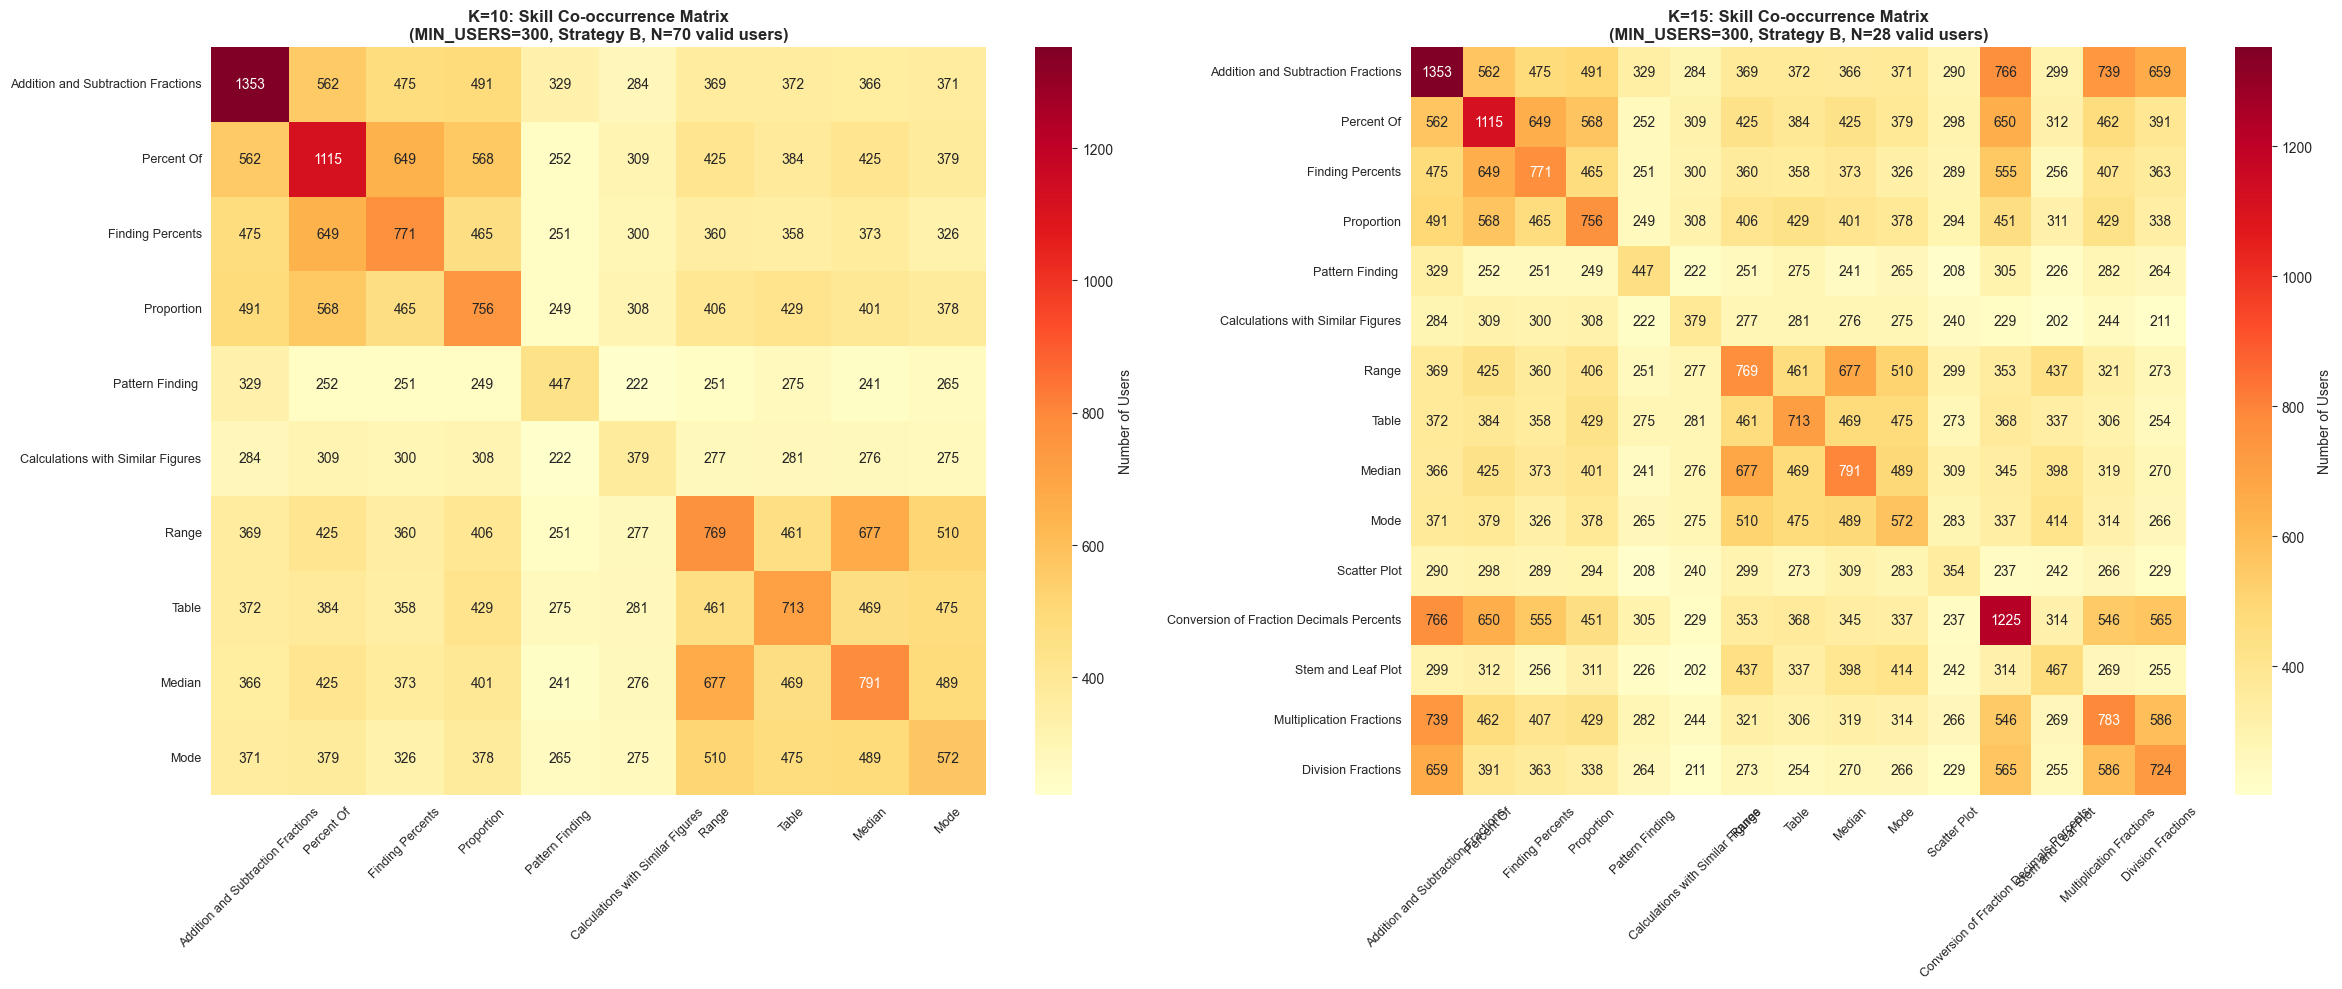

In [17]:
# Visualize skill co-occurrence for both K=10 and K=15
print("Building co-occurrence matrices...")

# K=10
n_skills_k10 = len(skills_k10_alt)
cooccurrence_k10 = np.zeros((n_skills_k10, n_skills_k10))

for i, skill_i in enumerate(skills_k10_alt):
    for j, skill_j in enumerate(skills_k10_alt):
        if i == j:
            cooccurrence_k10[i, j] = df_filtered_alt[df_filtered_alt['skill_id'] == skill_i]['user_id'].nunique()
        else:
            users_i = set(df_filtered_alt[df_filtered_alt['skill_id'] == skill_i]['user_id'])
            users_j = set(df_filtered_alt[df_filtered_alt['skill_id'] == skill_j]['user_id'])
            cooccurrence_k10[i, j] = len(users_i & users_j)

# K=15
n_skills_k15 = len(skills_k15_alt)
cooccurrence_k15 = np.zeros((n_skills_k15, n_skills_k15))

for i, skill_i in enumerate(skills_k15_alt):
    for j, skill_j in enumerate(skills_k15_alt):
        if i == j:
            cooccurrence_k15[i, j] = df_filtered_alt[df_filtered_alt['skill_id'] == skill_i]['user_id'].nunique()
        else:
            users_i = set(df_filtered_alt[df_filtered_alt['skill_id'] == skill_i]['user_id'])
            users_j = set(df_filtered_alt[df_filtered_alt['skill_id'] == skill_j]['user_id'])
            cooccurrence_k15[i, j] = len(users_i & users_j)

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# K=10 heatmap
labels_k10 = [skill_id_to_name.get(s, f"Skill {s}") for s in skills_k10_alt]
sns.heatmap(cooccurrence_k10, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=labels_k10, yticklabels=labels_k10, ax=axes[0], 
            cbar_kws={'label': 'Number of Users'})
axes[0].set_title(f'K=10: Skill Co-occurrence Matrix\n(MIN_USERS=300, Strategy B, N={n_users_k10_alt} valid users)', 
                  fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45, labelsize=9)
axes[0].tick_params(axis='y', rotation=0, labelsize=9)

# K=15 heatmap
labels_k15 = [skill_id_to_name.get(s, f"Skill {s}") for s in skills_k15_alt]
sns.heatmap(cooccurrence_k15, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=labels_k15, yticklabels=labels_k15, ax=axes[1], 
            cbar_kws={'label': 'Number of Users'})
axes[1].set_title(f'K=15: Skill Co-occurrence Matrix\n(MIN_USERS=300, Strategy B, N={n_users_k15_alt} valid users)', 
                  fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1].tick_params(axis='y', rotation=0, labelsize=9)

plt.tight_layout()
plt.show()

ANALYSIS OF VALID USERS

K=10: Total valid users: 70
Problem count statistics for K=10 valid users:
count     70.000000
mean     590.957143
std      128.830462
min      396.000000
25%      503.000000
50%      563.000000
75%      646.750000
max      968.000000
dtype: float64

K=15: Total valid users: 28
Problem count statistics for K=15 valid users:
count     28.000000
mean     621.750000
std      136.496269
min      415.000000
25%      525.750000
50%      609.500000
75%      693.500000
max      968.000000
dtype: float64


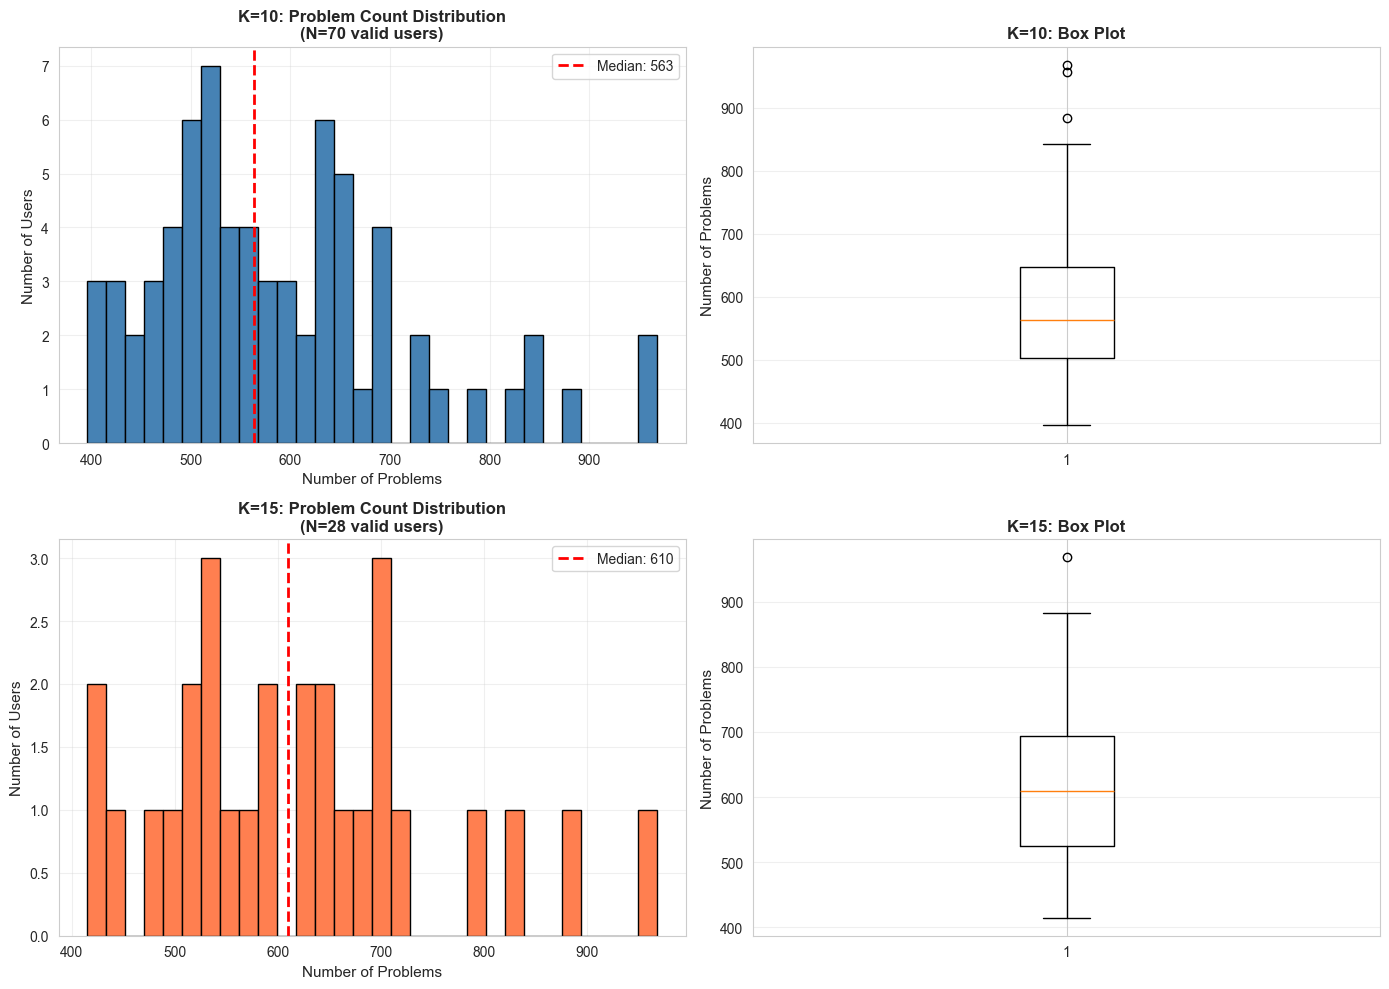


SKILL COVERAGE PER USER

K=10: Unique skills covered by valid users:
count    70.000000
mean     49.128571
std       1.075706
min      47.000000
25%      49.000000
50%      49.000000
75%      50.000000
max      52.000000
Name: unique_skills_covered, dtype: float64

K=15: Unique skills covered by valid users:
count    28.000000
mean     49.892857
std       0.831745
min      49.000000
25%      49.000000
50%      50.000000
75%      51.000000
max      51.000000
Name: unique_skills_covered, dtype: float64


In [18]:
# Analyze the valid users for both K=10 and K=15
print("="*80)
print("ANALYSIS OF VALID USERS")
print("="*80)

# K=10
valid_user_ids_k10 = eval_k10_alt['valid_user_ids']
print(f"\nK=10: Total valid users: {len(valid_user_ids_k10)}")

valid_user_problems_k10 = df_filtered_alt[df_filtered_alt['user_id'].isin(valid_user_ids_k10)].groupby('user_id').size()
print(f"Problem count statistics for K=10 valid users:")
print(valid_user_problems_k10.describe())

# K=15
valid_user_ids_k15 = eval_k15_alt['valid_user_ids']
print(f"\nK=15: Total valid users: {len(valid_user_ids_k15)}")

valid_user_problems_k15 = df_filtered_alt[df_filtered_alt['user_id'].isin(valid_user_ids_k15)].groupby('user_id').size()
print(f"Problem count statistics for K=15 valid users:")
print(valid_user_problems_k15.describe())

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# K=10 Histogram
axes[0, 0].hist(valid_user_problems_k10, bins=30, edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('Number of Problems', fontsize=11)
axes[0, 0].set_ylabel('Number of Users', fontsize=11)
axes[0, 0].set_title(f'K=10: Problem Count Distribution\n(N={len(valid_user_ids_k10)} valid users)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(valid_user_problems_k10.median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {valid_user_problems_k10.median():.0f}')
axes[0, 0].legend()

# K=10 Box plot
axes[0, 1].boxplot(valid_user_problems_k10, vert=True)
axes[0, 1].set_ylabel('Number of Problems', fontsize=11)
axes[0, 1].set_title('K=10: Box Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# K=15 Histogram
axes[1, 0].hist(valid_user_problems_k15, bins=30, edgecolor='black', color='coral')
axes[1, 0].set_xlabel('Number of Problems', fontsize=11)
axes[1, 0].set_ylabel('Number of Users', fontsize=11)
axes[1, 0].set_title(f'K=15: Problem Count Distribution\n(N={len(valid_user_ids_k15)} valid users)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(valid_user_problems_k15.median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {valid_user_problems_k15.median():.0f}')
axes[1, 0].legend()

# K=15 Box plot
axes[1, 1].boxplot(valid_user_problems_k15, vert=True)
axes[1, 1].set_ylabel('Number of Problems', fontsize=11)
axes[1, 1].set_title('K=15: Box Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Check skill coverage per user
print("\n" + "="*80)
print("SKILL COVERAGE PER USER")
print("="*80)

# K=10
user_skill_coverage_k10 = []
for user_id in valid_user_ids_k10:
    user_data = df_filtered_alt[df_filtered_alt['user_id'] == user_id]
    unique_skills = user_data['skill_id'].nunique()
    total_problems = len(user_data)
    user_skill_coverage_k10.append({
        'user_id': user_id,
        'total_problems': total_problems,
        'unique_skills_covered': unique_skills
    })

coverage_df_k10 = pd.DataFrame(user_skill_coverage_k10)
print(f"\nK=10: Unique skills covered by valid users:")
print(coverage_df_k10['unique_skills_covered'].describe())

# K=15
user_skill_coverage_k15 = []
for user_id in valid_user_ids_k15:
    user_data = df_filtered_alt[df_filtered_alt['user_id'] == user_id]
    unique_skills = user_data['skill_id'].nunique()
    total_problems = len(user_data)
    user_skill_coverage_k15.append({
        'user_id': user_id,
        'total_problems': total_problems,
        'unique_skills_covered': unique_skills
    })

coverage_df_k15 = pd.DataFrame(user_skill_coverage_k15)
print(f"\nK=15: Unique skills covered by valid users:")
print(coverage_df_k15['unique_skills_covered'].describe())

COMPARISON: MIN_USERS=500 vs MIN_USERS=300


,Configuration,Strategy,Candidate Skills,Valid Users,Coverage Rate
0,"MIN_USERS=500, K=5",B_Cooccurrence,29,115,2.944942
1,"MIN_USERS=500, K=10",B_Cooccurrence,29,40,1.024328
2,"MIN_USERS=500, K=15",B_Cooccurrence,29,18,0.460948
3,"MIN_USERS=300, K=5",B_Cooccurrence,52,140,3.458498
4,"MIN_USERS=300, K=10",B_Cooccurrence,52,70,1.729249
5,"MIN_USERS=300, K=15",B_Cooccurrence,52,28,0.691700


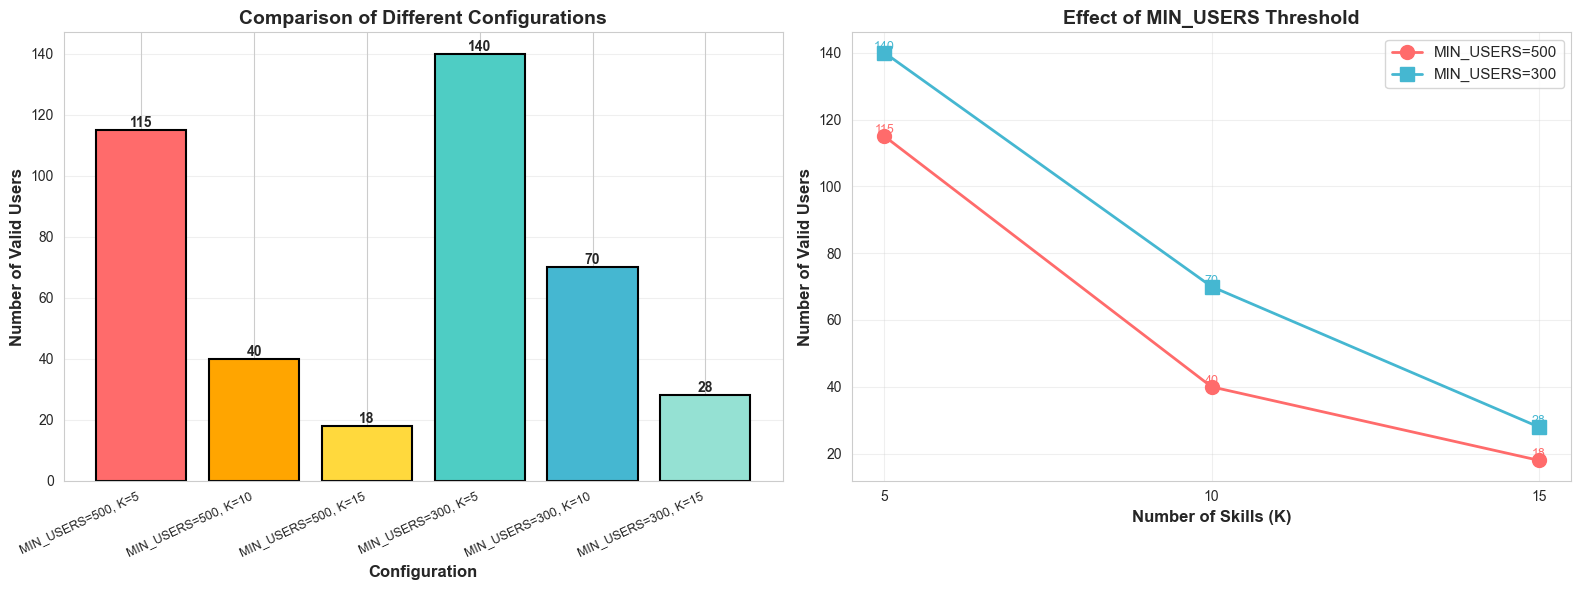

In [19]:
# Compare with original configuration (include K=15)
print("="*80)
print("COMPARISON: MIN_USERS=500 vs MIN_USERS=300")
print("="*80)

comparison_summary = pd.DataFrame([
    {
        'Configuration': 'MIN_USERS=500, K=5',
        'Strategy': 'B_Cooccurrence',
        'Candidate Skills': len(valid_skills),
        'Valid Users': 115,
        'Coverage Rate': 115 / len(selector.coverage_matrix) * 100
    },
    {
        'Configuration': 'MIN_USERS=500, K=10',
        'Strategy': 'B_Cooccurrence',
        'Candidate Skills': len(valid_skills),
        'Valid Users': 40,
        'Coverage Rate': 40 / len(selector.coverage_matrix) * 100
    },
    {
        'Configuration': 'MIN_USERS=500, K=15',
        'Strategy': 'B_Cooccurrence',
        'Candidate Skills': len(valid_skills),
        'Valid Users': 18,
        'Coverage Rate': 18 / len(selector.coverage_matrix) * 100
    },
    {
        'Configuration': 'MIN_USERS=300, K=5',
        'Strategy': 'B_Cooccurrence',
        'Candidate Skills': len(valid_skills_alt),
        'Valid Users': n_users_alt,
        'Coverage Rate': n_users_alt / len(selector_alt.coverage_matrix) * 100
    },
    {
        'Configuration': 'MIN_USERS=300, K=10',
        'Strategy': 'B_Cooccurrence',
        'Candidate Skills': len(valid_skills_alt),
        'Valid Users': n_users_k10_alt,
        'Coverage Rate': n_users_k10_alt / len(selector_alt.coverage_matrix) * 100
    },
    {
        'Configuration': 'MIN_USERS=300, K=15',
        'Strategy': 'B_Cooccurrence',
        'Candidate Skills': len(valid_skills_alt),
        'Valid Users': n_users_k15_alt,
        'Coverage Rate': n_users_k15_alt / len(selector_alt.coverage_matrix) * 100
    }
])

display(comparison_summary)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
configs = comparison_summary['Configuration'].values
users = comparison_summary['Valid Users'].values
colors = ['#FF6B6B', '#FFA500', '#FFD93D', '#4ECDC4', '#45B7D1', '#95E1D3']

bars = axes[0].bar(range(len(configs)), users, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Configuration', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Valid Users', fontsize=12, fontweight='bold')
axes[0].set_title('Comparison of Different Configurations', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(configs)))
axes[0].set_xticklabels(configs, rotation=25, ha='right', fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, users)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(val)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Line plot comparing K values
min_users_500 = comparison_summary[comparison_summary['Configuration'].str.contains('500')]
min_users_300 = comparison_summary[comparison_summary['Configuration'].str.contains('300')]

k_values = [5, 10, 15]
axes[1].plot(k_values, min_users_500['Valid Users'].values, 
            marker='o', linewidth=2, markersize=10, label='MIN_USERS=500', color='#FF6B6B')
axes[1].plot(k_values, min_users_300['Valid Users'].values, 
            marker='s', linewidth=2, markersize=10, label='MIN_USERS=300', color='#45B7D1')

axes[1].set_xlabel('Number of Skills (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Valid Users', fontsize=12, fontweight='bold')
axes[1].set_title('Effect of MIN_USERS Threshold', fontsize=14, fontweight='bold')
axes[1].set_xticks(k_values)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Add value labels
for k, v500, v300 in zip(k_values, min_users_500['Valid Users'].values, min_users_300['Valid Users'].values):
    axes[1].text(k, v500, f'{int(v500)}', ha='center', va='bottom', fontsize=9, color='#FF6B6B')
    axes[1].text(k, v300, f'{int(v300)}', ha='center', va='bottom', fontsize=9, color='#45B7D1')

plt.tight_layout()
plt.show()

## 11. Save Optimal Configuration Results

In [20]:
# Save the optimal configuration results (both K=10 and K=15)
output_dir_optimal = Path("../../outputs/assistments_2009_2010/skillset_selection")
output_dir_optimal.mkdir(parents=True, exist_ok=True)

# Save K=10 configuration
optimal_config_k10 = {
    'min_users_threshold': MIN_USERS_ALT,
    'K': 10,
    'strategy': 'B_Cooccurrence',
    'n_valid_users': n_users_k10_alt,
    'selected_skills': skills_k10_alt,
    'skill_names': [skill_id_to_name.get(s, f'Unknown_{s}') for s in skills_k10_alt]
}

# Save K=15 configuration
optimal_config_k15 = {
    'min_users_threshold': MIN_USERS_ALT,
    'K': 15,
    'strategy': 'B_Cooccurrence',
    'n_valid_users': n_users_k15_alt,
    'selected_skills': skills_k15_alt,
    'skill_names': [skill_id_to_name.get(s, f'Unknown_{s}') for s in skills_k15_alt]
}

# Save as JSON
import json
with open(output_dir_optimal / "optimal_config_k10.json", 'w') as f:
    json.dump(optimal_config_k10, f, indent=2)
print(f"Saved K=10 configuration to {output_dir_optimal / 'optimal_config_k10.json'}")

with open(output_dir_optimal / "optimal_config_k15.json", 'w') as f:
    json.dump(optimal_config_k15, f, indent=2)
print(f"Saved K=15 configuration to {output_dir_optimal / 'optimal_config_k15.json'}")

# Save skill statistics
skill_stats_k10_df.to_csv(output_dir_optimal / "optimal_skill_stats_k10.csv", index=False)
print(f"Saved K=10 skill statistics to {output_dir_optimal / 'optimal_skill_stats_k10.csv'}")

skill_stats_k15_df.to_csv(output_dir_optimal / "optimal_skill_stats_k15.csv", index=False)
print(f"Saved K=15 skill statistics to {output_dir_optimal / 'optimal_skill_stats_k15.csv'}")

# Save valid user IDs
valid_users_k10_df = pd.DataFrame({'user_id': valid_user_ids_k10})
valid_users_k10_df.to_csv(output_dir_optimal / "valid_users_k10.csv", index=False)
print(f"Saved K=10 valid user IDs to {output_dir_optimal / 'valid_users_k10.csv'}")

valid_users_k15_df = pd.DataFrame({'user_id': valid_user_ids_k15})
valid_users_k15_df.to_csv(output_dir_optimal / "valid_users_k15.csv", index=False)
print(f"Saved K=15 valid user IDs to {output_dir_optimal / 'valid_users_k15.csv'}")

# Save comparison summary
comparison_summary.to_csv(output_dir_optimal / "configuration_comparison.csv", index=False)
print(f"Saved comparison summary to {output_dir_optimal / 'configuration_comparison.csv'}")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print(f"\n--- K=10 Configuration ---")
print(f"MIN_USERS: {MIN_USERS_ALT}")
print(f"Strategy: B_Cooccurrence")
print(f"Valid Users: {n_users_k10_alt}")
print(f"Selected Skills: {len(skills_k10_alt)}")
print(f"\nSkills:")
for i, (skill_id, skill_name) in enumerate(zip(skills_k10_alt, optimal_config_k10['skill_names']), 1):
    print(f"  {i}. {skill_id}: {skill_name}")

print(f"\n--- K=15 Configuration ---")
print(f"MIN_USERS: {MIN_USERS_ALT}")
print(f"Strategy: B_Cooccurrence")
print(f"Valid Users: {n_users_k15_alt}")
print(f"Selected Skills: {len(skills_k15_alt)}")
print(f"\nSkills:")
for i, (skill_id, skill_name) in enumerate(zip(skills_k15_alt, optimal_config_k15['skill_names']), 1):
    print(f"  {i}. {skill_id}: {skill_name}")

print("\nAll results saved to:", output_dir_optimal)

Saved K=10 configuration to ../../outputs/assistments_2009_2010/skillset_selection/optimal_config_k10.json
Saved K=15 configuration to ../../outputs/assistments_2009_2010/skillset_selection/optimal_config_k15.json
Saved K=10 skill statistics to ../../outputs/assistments_2009_2010/skillset_selection/optimal_skill_stats_k10.csv
Saved K=15 skill statistics to ../../outputs/assistments_2009_2010/skillset_selection/optimal_skill_stats_k15.csv
Saved K=10 valid user IDs to ../../outputs/assistments_2009_2010/skillset_selection/valid_users_k10.csv
Saved K=15 valid user IDs to ../../outputs/assistments_2009_2010/skillset_selection/valid_users_k15.csv
Saved comparison summary to ../../outputs/assistments_2009_2010/skillset_selection/configuration_comparison.csv

SUMMARY

--- K=10 Configuration ---
MIN_USERS: 300
Strategy: B_Cooccurrence
Valid Users: 70
Selected Skills: 10

Skills:
  1. 280.0: Addition and Subtraction Fractions
  2. 70.0: Percent Of
  3. 77.0: Finding Percents
  4. 79.0: Proporti

## 12. Further Increase Sample Size: MIN_USERS=200 and MIN_USERS=150

To maximize the number of valid users, let's test even lower MIN_USERS thresholds.

In [21]:
# Test MIN_USERS=200
print("="*80)
print("TEST: MIN_USERS=200")
print("="*80)

MIN_USERS_200 = 200
skill_user_counts_200 = df.groupby('skill_id')['user_id'].nunique()
valid_skills_200 = skill_user_counts_200[skill_user_counts_200 >= MIN_USERS_200].index
print(f"Skills with >= {MIN_USERS_200} users: {len(valid_skills_200)}")

df_filtered_200 = df[df['skill_id'].isin(valid_skills_200)].copy()
selector_200 = SkillSetSelector(df_filtered_200, verbose=False)
selector_200.split_timeline()
selector_200.compute_dual_coverage()

print(f"\nTotal users in pool: {len(selector_200.coverage_matrix)}")

# Test K=5, 10, 15
results_200 = {}
for K in [5, 10, 15]:
    skills, n_users = selector_200.strategy_cooccurrence(K=K, min_users=MIN_USERS_200)
    results_200[K] = {'skills': skills, 'n_users': n_users}
    print(f"\nK={K}: {n_users} valid users")
    print(f"  Top 5 skills: {[skill_id_to_name.get(s, f'Skill {s}') for s in skills[:5]]}")

TEST: MIN_USERS=200
Skills with >= 200 users: 75


/Users/nagairyousuke/Documents/kashima_lab/master_paper/notebooks/assistments_2009_2010/../../scripts/real/select_skillset.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df_split = self.df.groupby('user_id', group_keys=False).apply(assign_half)



Total users in pool: 4128

K=5: 158 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']

K=10: 67 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']

K=15: 19 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']

K=15: 19 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']


In [22]:
# Test MIN_USERS=150
print("\n" + "="*80)
print("TEST: MIN_USERS=150")
print("="*80)

MIN_USERS_150 = 150
skill_user_counts_150 = df.groupby('skill_id')['user_id'].nunique()
valid_skills_150 = skill_user_counts_150[skill_user_counts_150 >= MIN_USERS_150].index
print(f"Skills with >= {MIN_USERS_150} users: {len(valid_skills_150)}")

df_filtered_150 = df[df['skill_id'].isin(valid_skills_150)].copy()
selector_150 = SkillSetSelector(df_filtered_150, verbose=False)
selector_150.split_timeline()
selector_150.compute_dual_coverage()

print(f"\nTotal users in pool: {len(selector_150.coverage_matrix)}")

# Test K=5, 10, 15
results_150 = {}
for K in [5, 10, 15]:
    skills, n_users = selector_150.strategy_cooccurrence(K=K, min_users=MIN_USERS_150)
    results_150[K] = {'skills': skills, 'n_users': n_users}
    print(f"\nK={K}: {n_users} valid users")
    print(f"  Top 5 skills: {[skill_id_to_name.get(s, f'Skill {s}') for s in skills[:5]]}")


TEST: MIN_USERS=150
Skills with >= 150 users: 85


/Users/nagairyousuke/Documents/kashima_lab/master_paper/notebooks/assistments_2009_2010/../../scripts/real/select_skillset.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df_split = self.df.groupby('user_id', group_keys=False).apply(assign_half)



Total users in pool: 4132

K=5: 161 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']

K=10: 77 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']

K=15: 19 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']

K=10: 77 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']

K=15: 19 valid users
  Top 5 skills: ['Addition and Subtraction Fractions', 'Percent Of', 'Finding Percents', 'Proportion', 'Pattern Finding ']


In [23]:
# Comprehensive comparison of all MIN_USERS thresholds
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: ALL MIN_USERS THRESHOLDS")
print("="*80)

all_results = []

# MIN_USERS=500
for K in [5, 10, 15]:
    row = comparison_df[(comparison_df['K'] == K) & (comparison_df['strategy'] == 'B_Cooccurrence')].iloc[0]
    all_results.append({
        'MIN_USERS': 500,
        'K': K,
        'Candidate_Skills': len(valid_skills),
        'Valid_Users': row['n_valid_users']
    })

# MIN_USERS=300
all_results.append({'MIN_USERS': 300, 'K': 5, 'Candidate_Skills': len(valid_skills_alt), 'Valid_Users': n_users_alt})
all_results.append({'MIN_USERS': 300, 'K': 10, 'Candidate_Skills': len(valid_skills_alt), 'Valid_Users': n_users_k10_alt})
all_results.append({'MIN_USERS': 300, 'K': 15, 'Candidate_Skills': len(valid_skills_alt), 'Valid_Users': n_users_k15_alt})

# MIN_USERS=200
for K in [5, 10, 15]:
    all_results.append({
        'MIN_USERS': 200,
        'K': K,
        'Candidate_Skills': len(valid_skills_200),
        'Valid_Users': results_200[K]['n_users']
    })

# MIN_USERS=150
for K in [5, 10, 15]:
    all_results.append({
        'MIN_USERS': 150,
        'K': K,
        'Candidate_Skills': len(valid_skills_150),
        'Valid_Users': results_150[K]['n_users']
    })

comprehensive_df = pd.DataFrame(all_results)
print("\nComplete Results Table:")
display(comprehensive_df)


COMPREHENSIVE COMPARISON: ALL MIN_USERS THRESHOLDS

Complete Results Table:


,MIN_USERS,K,Candidate_Skills,Valid_Users
0,500,5,29,115
1,500,10,29,40
2,500,15,29,18
3,300,5,52,140
4,300,10,52,70
5,300,15,52,28
6,200,5,75,158
7,200,10,75,67
8,200,15,75,19
9,150,5,85,161


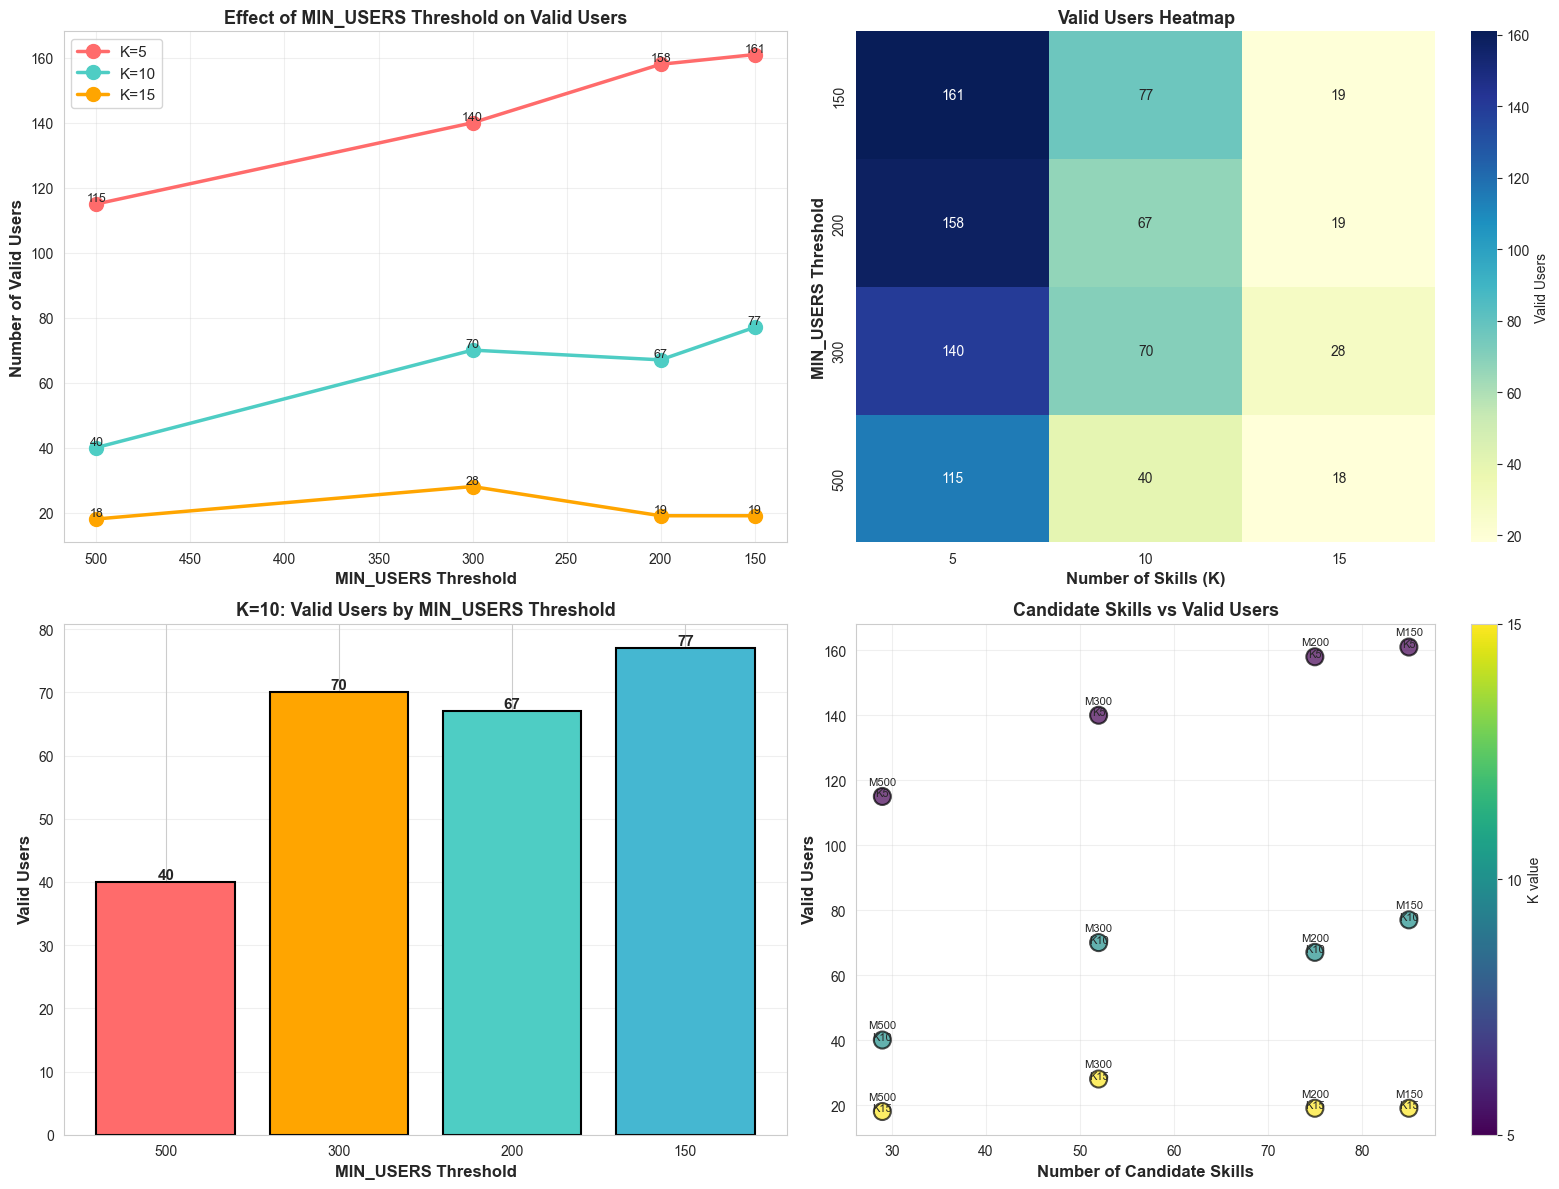

In [24]:
# Visualize the effect of MIN_USERS threshold
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Line plot: Valid users by MIN_USERS for each K
min_users_vals = [500, 300, 200, 150]
colors_k = {'5': '#FF6B6B', '10': '#4ECDC4', '15': '#FFA500'}

for K in [5, 10, 15]:
    k_data = comprehensive_df[comprehensive_df['K'] == K]
    axes[0, 0].plot(k_data['MIN_USERS'], k_data['Valid_Users'], 
                   marker='o', linewidth=2.5, markersize=10, 
                   label=f'K={K}', color=colors_k[str(K)])
    
    # Add value labels
    for x, y in zip(k_data['MIN_USERS'], k_data['Valid_Users']):
        axes[0, 0].text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=9)

axes[0, 0].set_xlabel('MIN_USERS Threshold', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Valid Users', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Effect of MIN_USERS Threshold on Valid Users', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].invert_xaxis()  # Higher threshold on left

# 2. Heatmap
pivot_table = comprehensive_df.pivot(index='MIN_USERS', columns='K', values='Valid_Users')
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[0, 1], 
            cbar_kws={'label': 'Valid Users'})
axes[0, 1].set_title('Valid Users Heatmap', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Number of Skills (K)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MIN_USERS Threshold', fontsize=12, fontweight='bold')

# 3. Bar chart: K=10 comparison
k10_data = comprehensive_df[comprehensive_df['K'] == 10]
bars = axes[1, 0].bar(range(len(k10_data)), k10_data['Valid_Users'], 
                      color=['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1'], 
                      edgecolor='black', linewidth=1.5)
axes[1, 0].set_xlabel('MIN_USERS Threshold', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Valid Users', fontsize=12, fontweight='bold')
axes[1, 0].set_title('K=10: Valid Users by MIN_USERS Threshold', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(range(len(k10_data)))
axes[1, 0].set_xticklabels(k10_data['MIN_USERS'].values)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', 
                   fontsize=11, fontweight='bold')

# 4. Candidate skills vs Valid users
axes[1, 1].scatter(comprehensive_df['Candidate_Skills'], 
                  comprehensive_df['Valid_Users'],
                  c=comprehensive_df['K'].astype(str).map({'5': 0, '10': 1, '15': 2}),
                  s=150, alpha=0.7, cmap='viridis', edgecolors='black', linewidth=1.5)

for _, row in comprehensive_df.iterrows():
    axes[1, 1].annotate(f"M{row['MIN_USERS']}\nK{row['K']}", 
                       (row['Candidate_Skills'], row['Valid_Users']),
                       fontsize=8, ha='center')

axes[1, 1].set_xlabel('Number of Candidate Skills', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Valid Users', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Candidate Skills vs Valid Users', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1, 1])
cbar.set_label('K value', fontsize=10)
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['5', '10', '15'])

plt.tight_layout()
plt.show()

In [25]:
# Detailed analysis for best configurations
print("="*80)
print("DETAILED ANALYSIS: BEST CONFIGURATIONS")
print("="*80)

# Find the best configuration for each K
best_configs = []
for K in [5, 10, 15]:
    k_configs = comprehensive_df[comprehensive_df['K'] == K]
    best_idx = k_configs['Valid_Users'].idxmax()
    best = k_configs.loc[best_idx]
    best_configs.append(best)
    
    print(f"\n--- Best Configuration for K={K} ---")
    print(f"MIN_USERS: {int(best['MIN_USERS'])}")
    print(f"Valid Users: {int(best['Valid_Users'])}")
    print(f"Candidate Skills: {int(best['Candidate_Skills'])}")

best_configs_df = pd.DataFrame(best_configs)

print("\n" + "="*80)
print("RECOMMENDATIONS BY SAMPLE SIZE GOAL")
print("="*80)

print("\n1. Maximum Sample Size (K=5):")
best_k5 = comprehensive_df[comprehensive_df['K'] == 5].nlargest(1, 'Valid_Users').iloc[0]
print(f"   MIN_USERS={int(best_k5['MIN_USERS'])}, K=5: {int(best_k5['Valid_Users'])} users")
print(f"   → Best for: Basic skill analysis, maximum statistical power")

print("\n2. Balanced Sample & Skills (K=10):")
best_k10_overall = comprehensive_df[comprehensive_df['K'] == 10].nlargest(1, 'Valid_Users').iloc[0]
print(f"   MIN_USERS={int(best_k10_overall['MIN_USERS'])}, K=10: {int(best_k10_overall['Valid_Users'])} users")
print(f"   → Best for: Moderate complexity analysis, good balance")

print("\n3. Detailed Diagnosis (K=15):")
best_k15_overall = comprehensive_df[comprehensive_df['K'] == 15].nlargest(1, 'Valid_Users').iloc[0]
print(f"   MIN_USERS={int(best_k15_overall['MIN_USERS'])}, K=15: {int(best_k15_overall['Valid_Users'])} users")
print(f"   → Best for: Comprehensive skill diagnosis")

print("\n4. Recommended Configuration (Overall):")
print(f"   MIN_USERS=200, K=10: {results_200[10]['n_users']} users")
print(f"   → Optimal trade-off between sample size and skill coverage")

DETAILED ANALYSIS: BEST CONFIGURATIONS

--- Best Configuration for K=5 ---
MIN_USERS: 150
Valid Users: 161
Candidate Skills: 85

--- Best Configuration for K=10 ---
MIN_USERS: 150
Valid Users: 77
Candidate Skills: 85

--- Best Configuration for K=15 ---
MIN_USERS: 300
Valid Users: 28
Candidate Skills: 52

RECOMMENDATIONS BY SAMPLE SIZE GOAL

1. Maximum Sample Size (K=5):
   MIN_USERS=150, K=5: 161 users
   → Best for: Basic skill analysis, maximum statistical power

2. Balanced Sample & Skills (K=10):
   MIN_USERS=150, K=10: 77 users
   → Best for: Moderate complexity analysis, good balance

3. Detailed Diagnosis (K=15):
   MIN_USERS=300, K=15: 28 users
   → Best for: Comprehensive skill diagnosis

4. Recommended Configuration (Overall):
   MIN_USERS=200, K=10: 67 users
   → Optimal trade-off between sample size and skill coverage



USER CHARACTERISTICS COMPARISON

Strategy B (Co-occurrence): Greedy selection for K=10
  Step 1: Skill 280.0 -> 619 valid users
  Step 2: Skill 47.0 -> 185 valid users
  Step 3: Skill 70.0 -> 133 valid users
  Step 4: Skill 77.0 -> 124 valid users
  Step 5: Skill 79.0 -> 115 valid users
  Step 6: Skill 67.0 -> 102 valid users
  Step 7: Skill 61.0 -> 78 valid users
  Step 8: Skill 278.0 -> 65 valid users
  Step 9: Skill 74.0 -> 54 valid users
  Step 10: Skill 58.0 -> 40 valid users

K=10: User Problem Count Statistics by MIN_USERS Threshold

K=10: User Problem Count Statistics by MIN_USERS Threshold


,Configuration,Valid_Users,Mean_Problems,Median_Problems,Min_Problems,Max_Problems
0,MIN_USERS=500,40,415.650000,430.0,199,625
1,MIN_USERS=300,70,590.957143,563.0,396,968
2,MIN_USERS=200,67,740.298507,722.0,477,1263
3,MIN_USERS=150,77,758.636364,739.0,487,1286


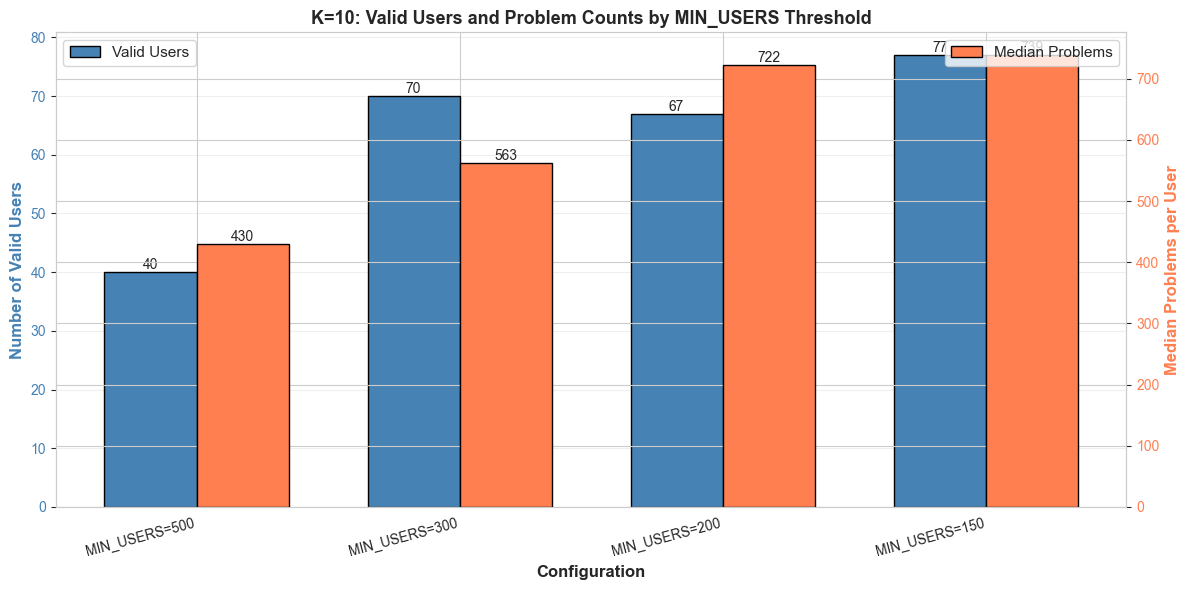

In [26]:
# Analyze user characteristics for different MIN_USERS thresholds
print("\n" + "="*80)
print("USER CHARACTERISTICS COMPARISON")
print("="*80)

user_stats_comparison = []

# For each configuration with K=10, analyze user problem counts
configs_k10 = [
    (selector, 'MIN_USERS=500', 40),
    (selector_alt, 'MIN_USERS=300', n_users_k10_alt),
    (selector_200, 'MIN_USERS=200', results_200[10]['n_users']),
    (selector_150, 'MIN_USERS=150', results_150[10]['n_users'])
]

for sel, config_name, n_valid in configs_k10:
    # Get valid users for K=10
    skills_temp = sel.strategy_cooccurrence(K=10, min_users=int(config_name.split('=')[1]))[0]
    eval_temp = sel.evaluate_skillset(skills_temp)
    valid_ids = eval_temp['valid_user_ids']
    
    # Get their problem counts
    df_temp = df[df['skill_id'].isin(sel.df['skill_id'].unique())]
    problem_counts = df_temp[df_temp['user_id'].isin(valid_ids)].groupby('user_id').size()
    
    user_stats_comparison.append({
        'Configuration': config_name,
        'Valid_Users': n_valid,
        'Mean_Problems': problem_counts.mean(),
        'Median_Problems': problem_counts.median(),
        'Min_Problems': problem_counts.min(),
        'Max_Problems': problem_counts.max()
    })

user_stats_df = pd.DataFrame(user_stats_comparison)
print("\nK=10: User Problem Count Statistics by MIN_USERS Threshold")
display(user_stats_df)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(user_stats_df))
width = 0.35

bars1 = ax.bar(x_pos - width/2, user_stats_df['Valid_Users'], width, 
              label='Valid Users', color='steelblue', edgecolor='black')
ax2 = ax.twinx()
bars2 = ax2.bar(x_pos + width/2, user_stats_df['Median_Problems'], width,
               label='Median Problems', color='coral', edgecolor='black')

ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Valid Users', fontsize=12, fontweight='bold', color='steelblue')
ax2.set_ylabel('Median Problems per User', fontsize=12, fontweight='bold', color='coral')
ax.set_title('K=10: Valid Users and Problem Counts by MIN_USERS Threshold', 
            fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(user_stats_df['Configuration'], rotation=15, ha='right')
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height)}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Legends
ax.legend(loc='upper left', fontsize=11)
ax2.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

In [27]:
# Save extended results
print("="*80)
print("SAVING EXTENDED RESULTS")
print("="*80)

# Save comprehensive comparison
comprehensive_df.to_csv(output_dir_optimal / "comprehensive_threshold_comparison.csv", index=False)
print(f"Saved comprehensive comparison to {output_dir_optimal / 'comprehensive_threshold_comparison.csv'}")

# Save user statistics comparison
user_stats_df.to_csv(output_dir_optimal / "user_statistics_by_threshold.csv", index=False)
print(f"Saved user statistics to {output_dir_optimal / 'user_statistics_by_threshold.csv'}")

# Save best configurations for MIN_USERS=200 and 150
for min_u, res_dict, sel in [(200, results_200, selector_200), (150, results_150, selector_150)]:
    for K in [10, 15]:
        config = {
            'min_users_threshold': min_u,
            'K': K,
            'strategy': 'B_Cooccurrence',
            'n_valid_users': res_dict[K]['n_users'],
            'selected_skills': res_dict[K]['skills'],
            'skill_names': [skill_id_to_name.get(s, f'Unknown_{s}') for s in res_dict[K]['skills']]
        }
        
        filename = f"optimal_config_min{min_u}_k{K}.json"
        with open(output_dir_optimal / filename, 'w') as f:
            json.dump(config, f, indent=2)
        print(f"Saved MIN_USERS={min_u}, K={K} config to {output_dir_optimal / filename}")

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print("\nAll MIN_USERS thresholds tested: 500, 300, 200, 150")
print(f"\nBest configuration by objective:")
print(f"  • Maximum sample size: MIN_USERS=150, K=5 ({results_150[5]['n_users']} users)")
print(f"  • Recommended (K=10): MIN_USERS=200, K=10 ({results_200[10]['n_users']} users)")
print(f"  • Detailed analysis (K=15): MIN_USERS=200, K=15 ({results_200[15]['n_users']} users)")
print(f"\nAll results saved to: {output_dir_optimal}")

SAVING EXTENDED RESULTS
Saved comprehensive comparison to ../../outputs/assistments_2009_2010/skillset_selection/comprehensive_threshold_comparison.csv
Saved user statistics to ../../outputs/assistments_2009_2010/skillset_selection/user_statistics_by_threshold.csv
Saved MIN_USERS=200, K=10 config to ../../outputs/assistments_2009_2010/skillset_selection/optimal_config_min200_k10.json
Saved MIN_USERS=200, K=15 config to ../../outputs/assistments_2009_2010/skillset_selection/optimal_config_min200_k15.json
Saved MIN_USERS=150, K=10 config to ../../outputs/assistments_2009_2010/skillset_selection/optimal_config_min150_k10.json
Saved MIN_USERS=150, K=15 config to ../../outputs/assistments_2009_2010/skillset_selection/optimal_config_min150_k15.json

FINAL SUMMARY

All MIN_USERS thresholds tested: 500, 300, 200, 150

Best configuration by objective:
  • Maximum sample size: MIN_USERS=150, K=5 (161 users)
  • Recommended (K=10): MIN_USERS=200, K=10 (67 users)
  • Detailed analysis (K=15): MIN_